## Preprocessing Sction.
This section is inspired by the preprocessing of another computer scientist who was using the same dataset to do their own experiments on it.

Link to their repositry: [TanushGoel / Breast-Histopathology-IDC-Classification](https://github.com/TanushGoel/Breast-Histopathology-IDC-Classification)

In [1]:
# Testing that the machine recognizes the GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import os
from os.path import isfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import utils
import itertools
import shutil
np.random.seed(42)
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.9.1
2.9.0


In [4]:
current_dir = os.getcwd()

In [5]:
#create new all image dir folder 
all_images_dir = 'all_images_dir_AUG'
os.chdir('./breast-histopathology-images/')
if(os.path.exists(f'./{all_images_dir}') == False):
    os.mkdir(all_images_dir)

    # Create Positive subdirectory within all images
    os.mkdir('all_images_dir_AUG/1')
    os.mkdir('all_images_dir_AUG/0')

In [6]:

# to get rid of changing the directory more than once
# os.chdir(current_dir)

###### Mostly, taken from the other author's notebook. ######

all_images_dir = 'all_images_dir_AUG'
# os.chdir('./breast-histopathology-images/')
# copies all images from their seperate folders into the same 
# folder called all_images_dir


# create a list of all patient id's
# each patient id folder has 2 sub folders --> folder 0 and folder 1

# Example:
    # '10285'
        # '0'
        # '1'
        
all_pos_len = len(os.listdir(f'{all_images_dir}/1'))
all_neg_len = len(os.listdir(f'{all_images_dir}/0'))


if all_pos_len == 0 or all_neg_len == 0:
    cur_dir = os.getcwd()
    patient_list = os.listdir(cur_dir)

    for patient in patient_list:

      try:

        path_0 = str(patient) + '/0'
        path_1 = str(patient) + '/1'

        # create a list of all files in folder 0
        file_list_0 = os.listdir(path_0)
        # create a list of list all file in folder 1
        file_list_1 = os.listdir(path_1)

        # move the 0 images to all_images_dir
        for fname in file_list_0:

            # source path to image
            src = os.path.join(path_0, fname)
            # destination path to image
            dst = os.path.join(all_images_dir, '0', fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

        # move the 1 images to all_images_dir
        for fname in file_list_1:

            # source path to image
            src = os.path.join(path_1, fname)
            # destination path to image
            dst = os.path.join(all_images_dir, '1', fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

      except:
         print(patient, 'cannot be copied into proper folder')
else:
    print("Data already exists. Skipped copying")

Data already exists. Skipped copying


In [7]:
# Check how many images are in each folder, to make sure we have correct data
print('Total:', all_pos_len + all_neg_len)
print('Positive:', all_pos_len)
print('Negative:', all_neg_len)

Total: 277524
Positive: 78786
Negative: 198738


In [8]:
###### Mostly, taken from the other author's notebook. ######

# Create a dataframe containing all the information

image_list_1 = os.listdir(f'{all_images_dir}/1')
df_data_1 = pd.DataFrame(image_list_1, columns=['image_id'])

image_list_0 = os.listdir(f'{all_images_dir}/0')
df_data_0 = pd.DataFrame(image_list_0, columns=['image_id'])

df_data = pd.concat([df_data_1, df_data_0])

In [9]:
# Validating that the data now exists in the dataframe
df_data.head()

,image_id
0,13462_idx5_x751_y1351_class1.png
1,9181_idx5_x2651_y651_class1.png
2,13687_idx5_x2351_y701_class1.png
3,13916_idx5_x1101_y1101_class1.png
4,10302_idx5_x2101_y151_class1.png


In [10]:
###### Mostly, taken from the other author's notebook. ######

# Define Helper Functions

# Each file name has this format:
# '14211_idx5_x2401_y1301_class1.png'

def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target

# extract the patient id

# create a new column called 'patient_id'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head()

,image_id,patient_id,target
0,13462_idx5_x751_y1351_class1.png,13462,1
1,9181_idx5_x2651_y651_class1.png,9181,1
2,13687_idx5_x2351_y701_class1.png,13687,1
3,13916_idx5_x1101_y1101_class1.png,13916,1
4,10302_idx5_x2101_y151_class1.png,10302,1


### The class distribution of the dataset.
There are more negative cases than the positive ones. This makes the dataset imbalanced since the nature of the problem doesn't require that the number of negative cases to be more or less than the positive ones.

Text(0.5, 1.0, 'Class Distributions')

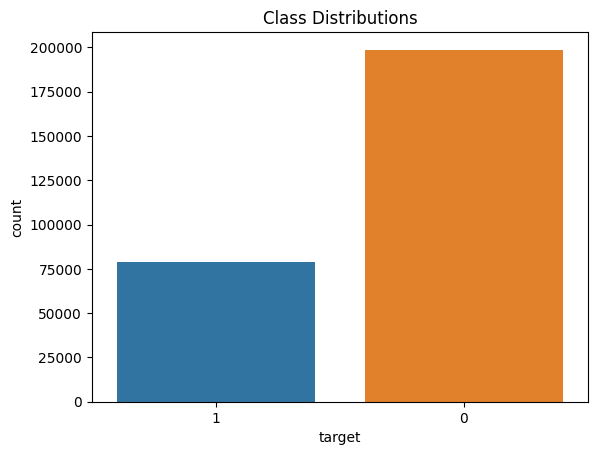

In [11]:
# Showing the class distribution of the dataset, We find that the negative is way more than the positives.
sns.countplot(x=df_data.target).set_title("Class Distributions")

# Train / Test / Validation

In [12]:
from sklearn.model_selection import train_test_split

y = df_data['target']

_, df_test = train_test_split(df_data, test_size=0.03603, random_state=42, stratify=y)

_, df_val = train_test_split(df_data, test_size=0.0036025, random_state=42, stratify=y)

print('Valid:', df_val.shape[0])
print('Test:', df_test.shape[0])

Valid: 1000
Test: 10000


Text(0.5, 1.0, 'Valid Class Distributions')

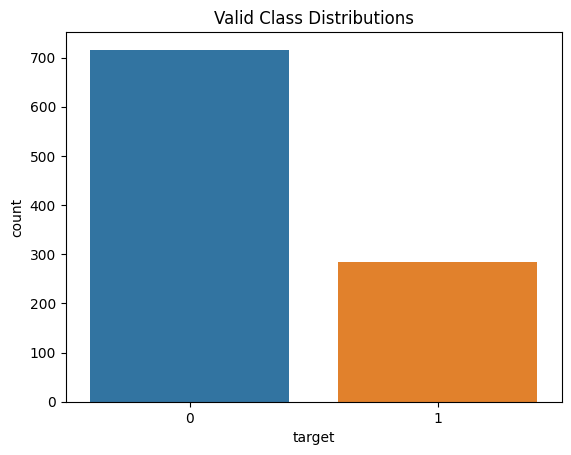

In [13]:
sns.countplot(x=df_val['target']).set_title('Valid Class Distributions')

Text(0.5, 1.0, 'Test Class Distributions')

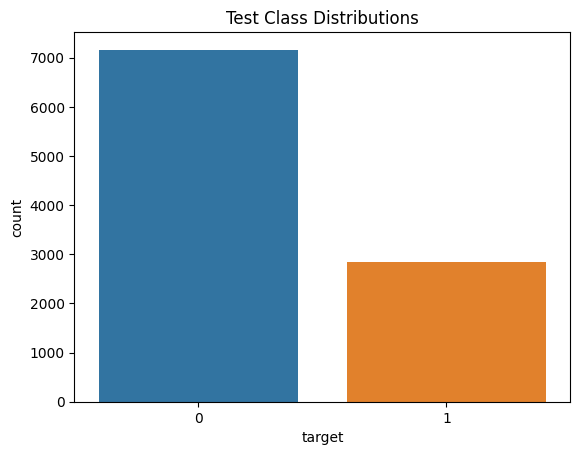

In [14]:
sns.countplot(x=df_test['target']).set_title('Test Class Distributions')

In [15]:
# Improved the speed of the identification through using a dictionary... Dramatically.
val_dict = df_val.set_index('image_id').T.to_dict('list')
test_dict = df_test.set_index('image_id').T.to_dict('list')

def identify_train_val_and_test_rows(x):
    if str(x) in val_dict:
        return 'val'
    elif str(x) in test_dict:
        return 'test'
    else:
        return 'train'

# create a new colum that is a copy of the image_id column
df_data['train_or_val_or_test'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val_or_test'] = df_data['train_or_val_or_test'].apply(identify_train_val_and_test_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val_or_test'] == 'train']

print('Train:', len(df_train))
print('Valid:', len(df_val))
print('Test:', len(df_test))

Train: 267524
Valid: 1000
Test: 10000


Text(0.5, 1.0, 'Train Class Distributions')

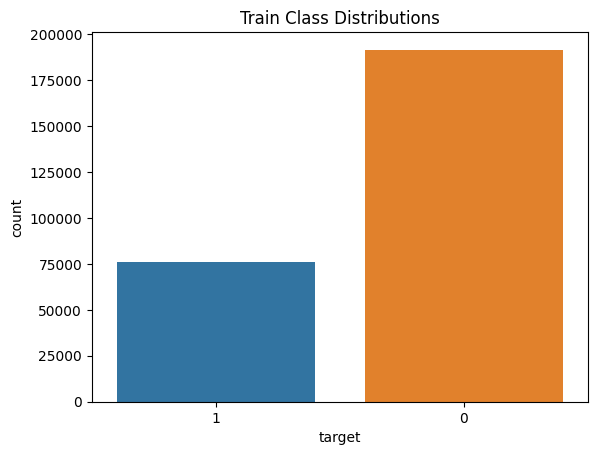

In [16]:
sns.countplot(x=df_train['target']).set_title('Train Class Distributions')

In [17]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)
df_data.head()

,patient_id,target,train_or_val_or_test
image_id,,,
13462_idx5_x751_y1351_class1.png,13462,1,train
9181_idx5_x2651_y651_class1.png,9181,1,train
13687_idx5_x2351_y701_class1.png,13687,1,train
13916_idx5_x1101_y1101_class1.png,13916,1,train
10302_idx5_x2101_y151_class1.png,10302,1,train


In [18]:
# Make Train, Valid, and Test Folders


# Create folders within the train, valid, and test folders
# Inside each folder we create seperate folders for each class

# train_dir
train_dir = os.path.join('train_dir_AUG')
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)
    # create new folders inside train_dir
    os.mkdir(os.path.join(train_dir, '1'))
    os.mkdir(os.path.join(train_dir, '0'))
    
# val_dir
val_dir = os.path.join('val_dir_AUG')
if not os.path.isdir(val_dir):
    os.mkdir(val_dir)
    # Create new folders inside val_dir
    os.mkdir(os.path.join(val_dir, '1'))
    os.mkdir(os.path.join(val_dir, '0'))

# test_dir
test_dir = os.path.join('test_dir_AUG')
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)
    # Create new folders inside test_dir
    os.mkdir(os.path.join(test_dir, '1'))
    os.mkdir(os.path.join(test_dir, '0'))

In [19]:
# Transfering the data from the starting directory to the training directory
if len(os.listdir(os.path.join(train_dir, '1'))) == 0:
    # Get a dict of train, val, and test images
    train_dict = df_train.set_index('image_id').T.to_dict('list')
    test_dict = df_test.set_index('image_id').T.to_dict('list')
    val_dict = df_val.set_index('image_id').T.to_dict('list')

    # Transfer the train images
    for image in train_dict:
        pat_id = df_data.loc[image,'patient_id']
        label = df_data.loc[image,'target']
        src = pat_id + '/' + label + '/' + image

        # destination path to image
        dst = os.path.join(train_dir, label, image)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


    # Transfer the val images
    for image in val_dict:
        pat_id = df_data.loc[image,'patient_id']
        label = df_data.loc[image,'target']
        src = pat_id + '/' + label + '/' + image

        # destination path to image
        dst = os.path.join(val_dir, label, image)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


    # Transfer the test images
    for image in test_dict:
        pat_id = df_data.loc[image,'patient_id']
        label = df_data.loc[image,'target']
        src = pat_id + '/' + label + '/' + image

        # destination path to image
        dst = os.path.join(test_dir, label, image)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
else:
    print("Data already exists (Hopefully), it might not be transfered correctly.")

Data already exists (Hopefully), it might not be transfered correctly.


In [20]:
print('Train Total:', len(os.listdir('train_dir_AUG/1'))+len(os.listdir('train_dir_AUG/0')))
print('Valid Total:', len(os.listdir('val_dir_AUG/1'))+len(os.listdir('val_dir_AUG/0')))
print('Test Total:', len(os.listdir('test_dir_AUG/1'))+len(os.listdir('test_dir_AUG/0')), '\n')

print('Train Negative:', len(os.listdir('train_dir_AUG/0')))
print('Train Positive:', len(os.listdir('train_dir_AUG/1')), '\n')

print('Valid Negative:', len(os.listdir('val_dir_AUG/0')))
print('Valid Positive:', len(os.listdir('val_dir_AUG/1')), '\n')

print('Test Negative:', len(os.listdir('test_dir_AUG/0')))
print('Test Positive:', len(os.listdir('test_dir_AUG/1')))

Train Total: 267524
Valid Total: 1000
Test Total: 10000 

Train Negative: 191577
Train Positive: 75947 

Valid Negative: 716
Valid Positive: 284 

Test Negative: 7161
Test Positive: 2839


# Agumentation


In [21]:
image_size = 100

from keras.preprocessing.image import ImageDataGenerator

# create temporary directories here and delete these directories later
aug_dir = 'aug_dir'
os.mkdir(aug_dir)
# create a dir within the base dir to store images of the same class
img_dir = os.path.join(aug_dir, 'img_dir')
os.mkdir(img_dir)

# list all images in that directory
img_list = os.listdir('train_dir_AUG/1')

# copy images from the class all images directory to the image directory
for fname in img_list:
    # source path to image
    src = os.path.join('train_dir_AUG/1', fname)
    # destination path to image
    dst = os.path.join(img_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# point to a dir containing the images and not to the images themselves
path = 'aug_dir'
save_path = 'train_dir_AUG/1'

# create a data generator
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.5,1.2],
    fill_mode='reflect'
)

batch_size = 25

aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size)

# generate the augmented images and add them to the folder of all images

num_aug_images_wanted = len(os.listdir('train_dir_AUG/0')) # total number of images wanted in each class

num_files = len(os.listdir(img_dir))
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

for i in range(0, num_batches):
  next(aug_datagen)

# delete temporary directory with the raw image files
shutil.rmtree('aug_dir')


# Check how many train images we have in each folder

print('Train Total:', len(os.listdir('train_dir_AUG/1'))+len(os.listdir('train_dir_AUG/0')))
print('Train Positive:', len(os.listdir('train_dir_AUG/1')))
print('Train Negative:', len(os.listdir('train_dir_AUG/0')))

Found 75947 images belonging to 1 classes.
Train Total: 383171
Train Positive: 191594
Train Negative: 191577


### Create train / test / validation batches

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = 'train_dir_AUG'
valid_path = 'val_dir_AUG'
test_path = 'test_dir_AUG'

num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 500
val_batch_size = 500

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [23]:
datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input, 
                             horizontal_flip=True,
                             vertical_flip=True)
image_size=100

train_batches_bench = datagen.flow_from_directory(train_path, 
                                                  target_size=(image_size, image_size),
                                                  batch_size=train_batch_size)

valid_batches_bench = datagen.flow_from_directory(valid_path,  
                                                  target_size=(image_size, image_size),
                                                  batch_size=val_batch_size)

test_batches_bench = datagen.flow_from_directory(test_path,  
                                                 target_size=(image_size, image_size),
                                                 batch_size=1,
                                                 shuffle=False) # test dataset should not be shuffled

Found 383171 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


## Train Baseline Model (VGG19)

In [24]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3)
)


2022-10-22 02:26:52.704849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 02:26:53.191990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15194 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:65:00.0, compute capability: 6.1


In [25]:
for layer in vgg.layers:
  layer.trainable = False

In [26]:
x = tf.keras.layers.Flatten()(vgg.output)  # One flatten layer
prediction = tf.keras.layers.Dense(2, activation='softmax')(x) # one softmax layer
model = tf.keras.Model(inputs=vgg.input, outputs=prediction)   # Final Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [27]:
# This needs to be checked
# We need to know which data to be added exactly. We want the Image Data Generator function but without any agumentation (for now)
# did not have time to check exactly how. 
# Try to compare with the paper stuff. Hopefully we will be able to find something.
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath='breast_histopathology_baseline_AUG.hdf5', verbose=1, save_best_only=True)

class_weights={
    0: 1.0, # negative
    1: 1.0, # postive 
    # make model more sensitive to positive class if necessary
}

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy']) 
history = model.fit(train_batches_bench, 
                                            steps_per_epoch=train_steps, 
                                            class_weight=class_weights,
                                            validation_data=valid_batches_bench,
                                            validation_steps=val_steps,
                                            callbacks=[model_checkpoint], 
                                            epochs=30, 
                                            verbose=1)

Epoch 1/30


2022-10-22 02:26:55.120086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-22 02:26:55.439894: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


536/536 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.8196
Epoch 1: val_loss improved from inf to 0.61598, saving model to breast_histopathology_baseline_AUG.hdf5
536/536 [==============================] - 261s 476ms/step - loss: 0.4032 - accuracy: 0.8196 - val_loss: 0.6160 - val_accuracy: 0.7270
Epoch 2/30
536/536 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8400
Epoch 2: val_loss improved from 0.61598 to 0.43568, saving model to breast_histopathology_baseline_AUG.hdf5
536/536 [==============================] - 255s 475ms/step - loss: 0.3663 - accuracy: 0.8400 - val_loss: 0.4357 - val_accuracy: 0.8040
Epoch 3/30
536/536 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8438
Epoch 3: val_loss did not improve from 0.43568
536/536 [==============================] - 255s 474ms/step - loss: 0.3594 - accuracy: 0.8438 - val_loss: 0.4716 - val_accuracy: 0.7890
Epoch 4/30
536/536 [==============================] - ETA: 

536/536 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8541
Epoch 29: val_loss did not improve from 0.41491
536/536 [==============================] - 255s 475ms/step - loss: 0.3395 - accuracy: 0.8541 - val_loss: 0.4373 - val_accuracy: 0.7950
Epoch 30/30
536/536 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.8542
Epoch 30: val_loss did not improve from 0.41491
536/536 [==============================] - 255s 475ms/step - loss: 0.3403 - accuracy: 0.8542 - val_loss: 0.4948 - val_accuracy: 0.7720


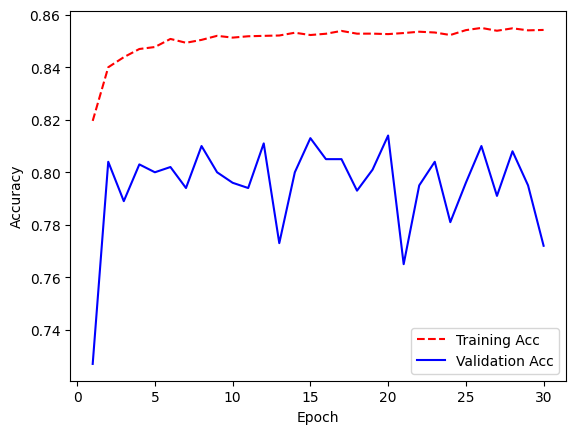

In [28]:
import matplotlib.pyplot as plt
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1, 31)

plt.figure()
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig("../vgg19-baseline-model-AUG.png")
plt.show()


In [29]:
# Load Weights of the Baseline Model
model.load_weights('breast_histopathology_baseline_AUG.hdf5')

In [30]:
# Test Predictions
preds = model.predict_generator(test_batches_bench, steps=len(df_test), verbose=1)

/tmp/ipykernel_796396/511020021.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_batches_bench, steps=len(df_test), verbose=1)


10000/10000 [==============================] - 68s 7ms/step


In [31]:
# Accuracy using the baseline model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
# Take the highest probability scores to get index of predictions for test images
y_pred = np.argmax(preds, axis=1)

# Get labels of test images
y_true = test_batches_bench.classes

# Evaluate
print(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%')

print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):1.3f}%')
# Balanced accuracy is calculated as the average of the proportion correct of each class individually

f = open("../testOutput_AUG.txt", "w")
f.write(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%\n')
f.write(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):1.3f}%\n')
f.close()

Accuracy: 0.820%
Balanced Accuracy: 0.763%


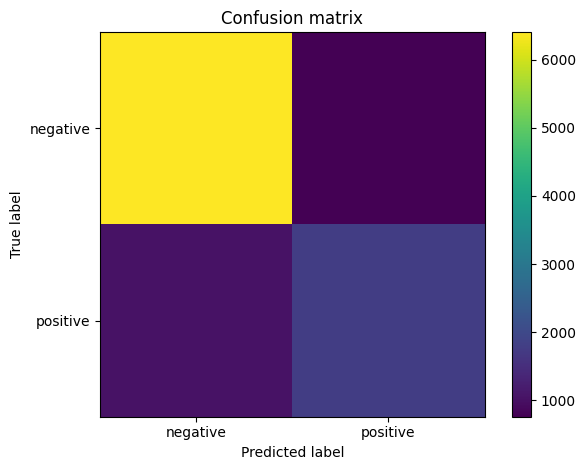

In [32]:
# Confusion matrix for the baseline model
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(['negative', 'positive']))
plt.xticks(tick_marks, ['negative', 'positive'])
plt.yticks(tick_marks, ['negative', 'positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("../vgg19-baseline-model-confusion-matrix-AUG.png")

In [33]:
confusionmatrix = confusion_matrix(y_true, y_pred)

f = open("../testOutput_AUG.txt", "a")
f.write(f'Confusion matrix: {confusionmatrix}\n')
f.close()

confusionmatrix

array([[6400,  761],
       [1043, 1796]])

In [34]:
from sklearn.metrics import classification_report
report = classification_report(y_true=y_true, y_pred=y_pred, target_names=['negative', 'positive'])

f = open("../testOutput_AUG.txt", "a")
f.write(f'REPORT:\n {report}\n')
f.close()

print(report)

              precision    recall  f1-score   support

    negative       0.86      0.89      0.88      7161
    positive       0.70      0.63      0.67      2839

    accuracy                           0.82     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.82      0.82      0.82     10000



IDC negative

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


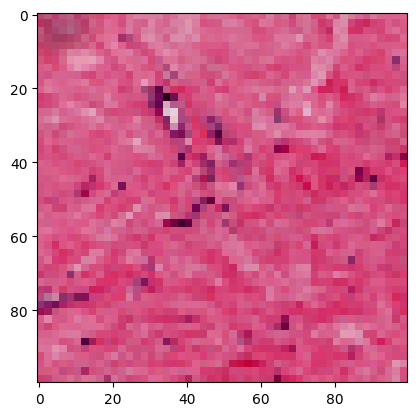

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative


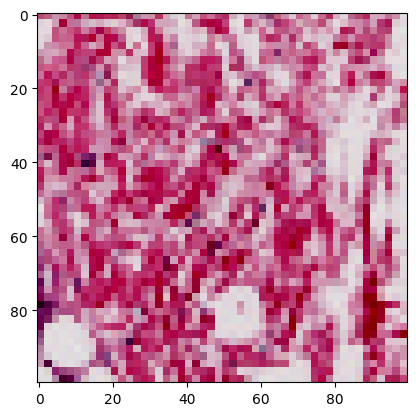

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative


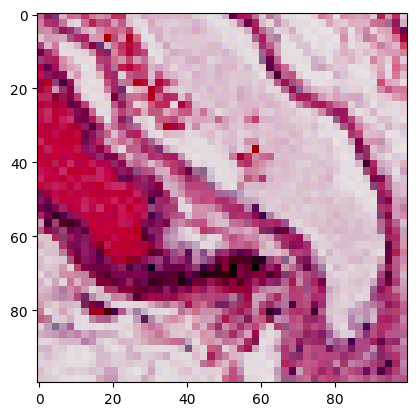

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative


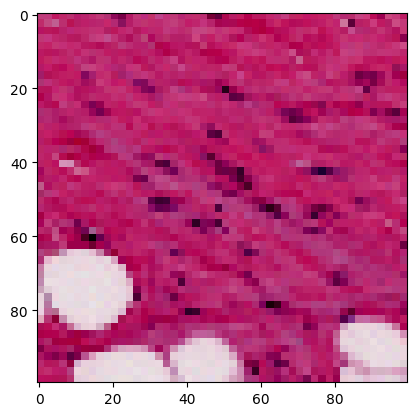

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative


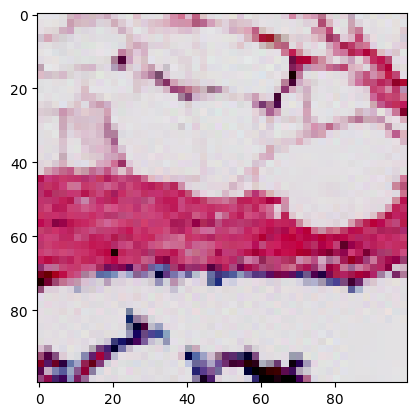

IDC positive


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


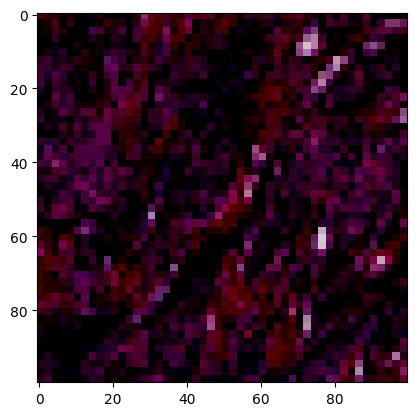

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative


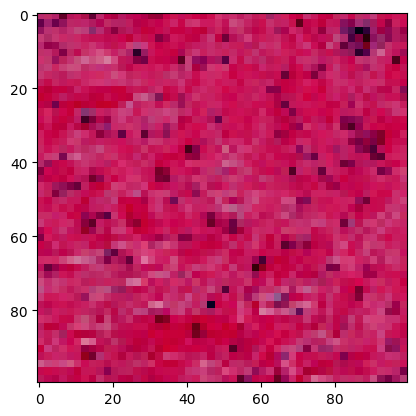

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative


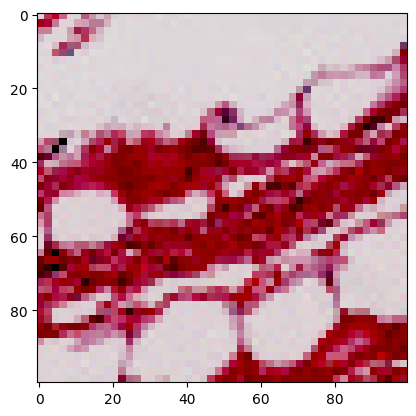

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC positive


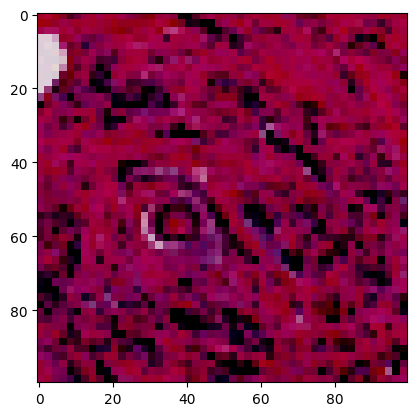

In [35]:
x, y = valid_batches_bench.next()

for i in range(1,10):
  
  image = x[i]
  label = y[i]
#   f = open("../testOutput_AUG.txt", "a")
  if np.argmax(label, axis=0) == 0:
      print('IDC negative')
#       f.write(f'IDC negative\n')
  if np.argmax(label, axis=0) == 1:
    print('IDC positive')
#     f.write(f'IDC positive\n')

#   print(image.shape)
#   prob = model.predict(image)
#   for a in prob:
#     for b in a:
#       print(f'Predicted Negative Probability: {(b*100):1.2f}%')
#       print(f'Predicted Positive Probability: {(1-b)*100:1.2f}%')
#       f.write(f'Predicted Negative Probability: {(b*100):1.2f}%\n')
#       f.write(f'Predicted Positive Probability: {(1-b)*100:1.2f}%\n')
#       break

  plt.imshow(image)
#   f.write(image)
  plt.show()
#   f.close()